# Method 1

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import matplotlib.pyplot as plt
import json
import pandas as pd
from collections import Counter
import numpy as np
import math
import requests
import yfinance as yf
import seaborn as sns
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf 

# Load the Data

In [ ]:
dates = pd.date_range(start="2009-01-02 00:00:00", end="2019-09-24 00:00:00", freq='D',
                      tz="Europe/London")

In [ ]:
dates = dates.map(lambda x:x.date())

In [ ]:
currency_tickers = ['INR=X']
us_treasury_bonds = [] #['^IRX','^FVX','^TNX','^TYX']
futures = [] #['DX-Y.NYB','GC=F','SI=F','BZ=F','^BSESN','^IXIC']

start = "2009-1-2"
end = "2019-9-23"

df_value = pd.DataFrame()
df_value['Date'] = dates
df_value.set_index('Date',inplace=True)

for ticker in (currency_tickers+us_treasury_bonds+futures):
    print(ticker,'Running')
    data=yf.Ticker(ticker).history(start=start, end=end)
    try:
        data.index=data.index.map(lambda x:x.tz_convert('Europe/London').date())
    except:
        data.index=data.index.map(lambda x:x.date())
    for i,index in enumerate(df_value.index.tolist()[:-1]):
        try:
            if index not in data.index.tolist():
                
                data.loc[index] = data.loc[df_value.index.tolist()[i-1]]
        except:
            pass
    data.sort_index(axis=0,inplace=True)
    if ticker != 'INR=X':
        df_value[ticker] = data['Close']
    else:
        df_value[ticker+'_Open'] = data['Open']
        df_value[ticker+'_Close'] = data['Close']
        df_value[ticker+'_High'] = data['High']
        df_value[ticker+'_Low'] = data['Low']

INR=X Running


In [ ]:
df_value.dropna(inplace=True)

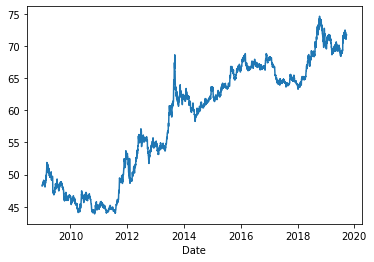

In [ ]:
df_value['INR=X_Close'].plot()

De-Trending the data.

In [ ]:
differenced = df_value[['INR=X_Close']].diff()[1:]
undifferenced = df_value[['INR=X_Close']][1:]

Min Max Scalar

In [ ]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(np.array(differenced).reshape((differenced.shape[0],1)))
Y_data = Y_scaler.fit_transform(np.array(differenced).reshape((differenced.shape[0],1)))

undifferenced = np.array(undifferenced).reshape((undifferenced.shape[0],1))

Generate Training Data

In [ ]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicey = range(i, i+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y) 

In [ ]:
hist_window = 30
horizon = 10
TRAIN_SPLIT = 3000
X_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
X_val, y_val = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

X_train_v, y_train_v = custom_ts_multi_data_prep(undifferenced, undifferenced, 0, TRAIN_SPLIT, hist_window, horizon)
X_val_v, y_val_v = custom_ts_multi_data_prep(undifferenced, undifferenced, TRAIN_SPLIT, None, hist_window, horizon)

Work Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout

In [ ]:
lstm_model = Sequential()
lstm_model.add(GRU(64, input_shape=X_train.shape[-2:], return_sequences=True))
lstm_model.add(LSTM(256))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(units=horizon))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 64)            12864     
                                                                 
 lstm (LSTM)                 (None, 256)               328704    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 358,666
Trainable params: 358,666
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model = tf.keras.models.Sequential([tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True), input_shape=X_train.shape[-2:]),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
     tf.keras.layers.Dense(128, activation='tanh'),                                    
     tf.keras.layers.Dense(64, activation='tanh'),
     tf.keras.layers.Dense(units=horizon)
 ])
lstm_model.compile(optimizer='rmsprop', loss='mse')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 20, 512)          528384    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 1,226,570
Trainable params: 1,226,570
Non-

Training

In [ ]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min')
callbacks=[early_stopings,checkpoint] 
history = lstm_model.fit(X_train,y_train,epochs=50,validation_data=[X_val, y_val],callbacks=callbacks,batch_size = 64)

Epoch 1/50
47/47 [==============================] - 13s 186ms/step - loss: 0.0233 - val_loss: 0.0020
Epoch 2/50
47/47 [==============================] - 8s 167ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 3/50
47/47 [==============================] - 8s 168ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 4/50
47/47 [==============================] - 9s 195ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 5/50
47/47 [==============================] - 8s 176ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 6/50
47/47 [==============================] - 8s 171ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/50
47/47 [==============================] - 8s 169ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/50
47/47 [==============================] - 8s 168ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 9/50
47/47 [==============================] - 8s 168ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 10/50
47/47 [==============================] - 8s 167ms/step - loss: 0.0019 - val_loss: 0.001

In [ ]:
pred=Y_scaler.inverse_transform(lstm_model.predict(X_val))
truth=Y_scaler.inverse_transform(y_val.reshape(y_val.shape[:2]))

Re-Trending the output

In [ ]:
y_retrend_val = []
for record in range(len(truth)):
    y = [X_val_v[record][-1][-1]]
    for val in truth[record]:
        y.append(y[-1]+val)
    y_retrend_val.append(y[1:])
y_retrend_val = np.array(y_retrend_val)

In [ ]:
y_retrend_pred = []
for record in range(len(pred)):
    y = [X_val_v[record][-1][-1]]
    for val in pred[record]:
        y.append(y[-1]+val)
    y_retrend_pred.append(y[1:])
y_retrend_pred = np.array(y_retrend_pred)

Performance

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

df_out_mape = pd.DataFrame()

Truth = y_retrend_val
Predictions = y_retrend_pred

rmse = []
mape = []
for i in range(10):
    #Print MSE to see how good the model is
    Error = mean_squared_error(Truth[:,i], Predictions[:,i])
    rmse.append(Error**0.5)

    MAPE = mean_absolute_percentage_error(Truth[:,i], Predictions[:,i])
    mape.append(MAPE)

df_out_mape['MAPE'] = mape
df_out_mape['RMSE'] = rmse

In [ ]:
df_out_mape

,MAPE,RMSE
0,0.002542,0.268251
1,0.003659,0.351800
2,0.004314,0.414200
3,0.004907,0.460617
4,0.005390,0.495814
5,0.005927,0.530988
6,0.006406,0.572152
7,0.006931,0.636741
8,0.007451,0.684624
9,0.007853,0.718579


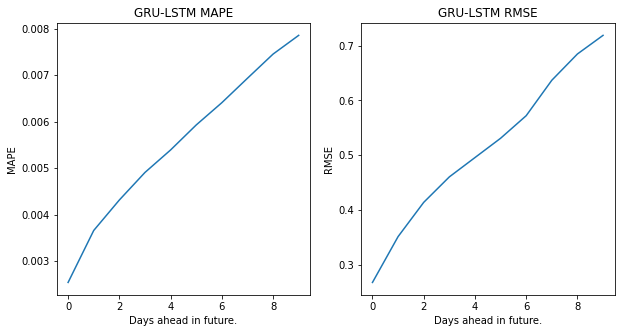

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('GRU-LSTM MAPE')
plt.plot(df_out_mape['MAPE'])
plt.xlabel('Days ahead in future.')
plt.ylabel('MAPE')
plt.subplot(1,2,2)
plt.title('GRU-LSTM RMSE')
plt.plot(df_out_mape['RMSE'])
plt.xlabel('Days ahead in future.')
plt.ylabel('RMSE')
plt.show()

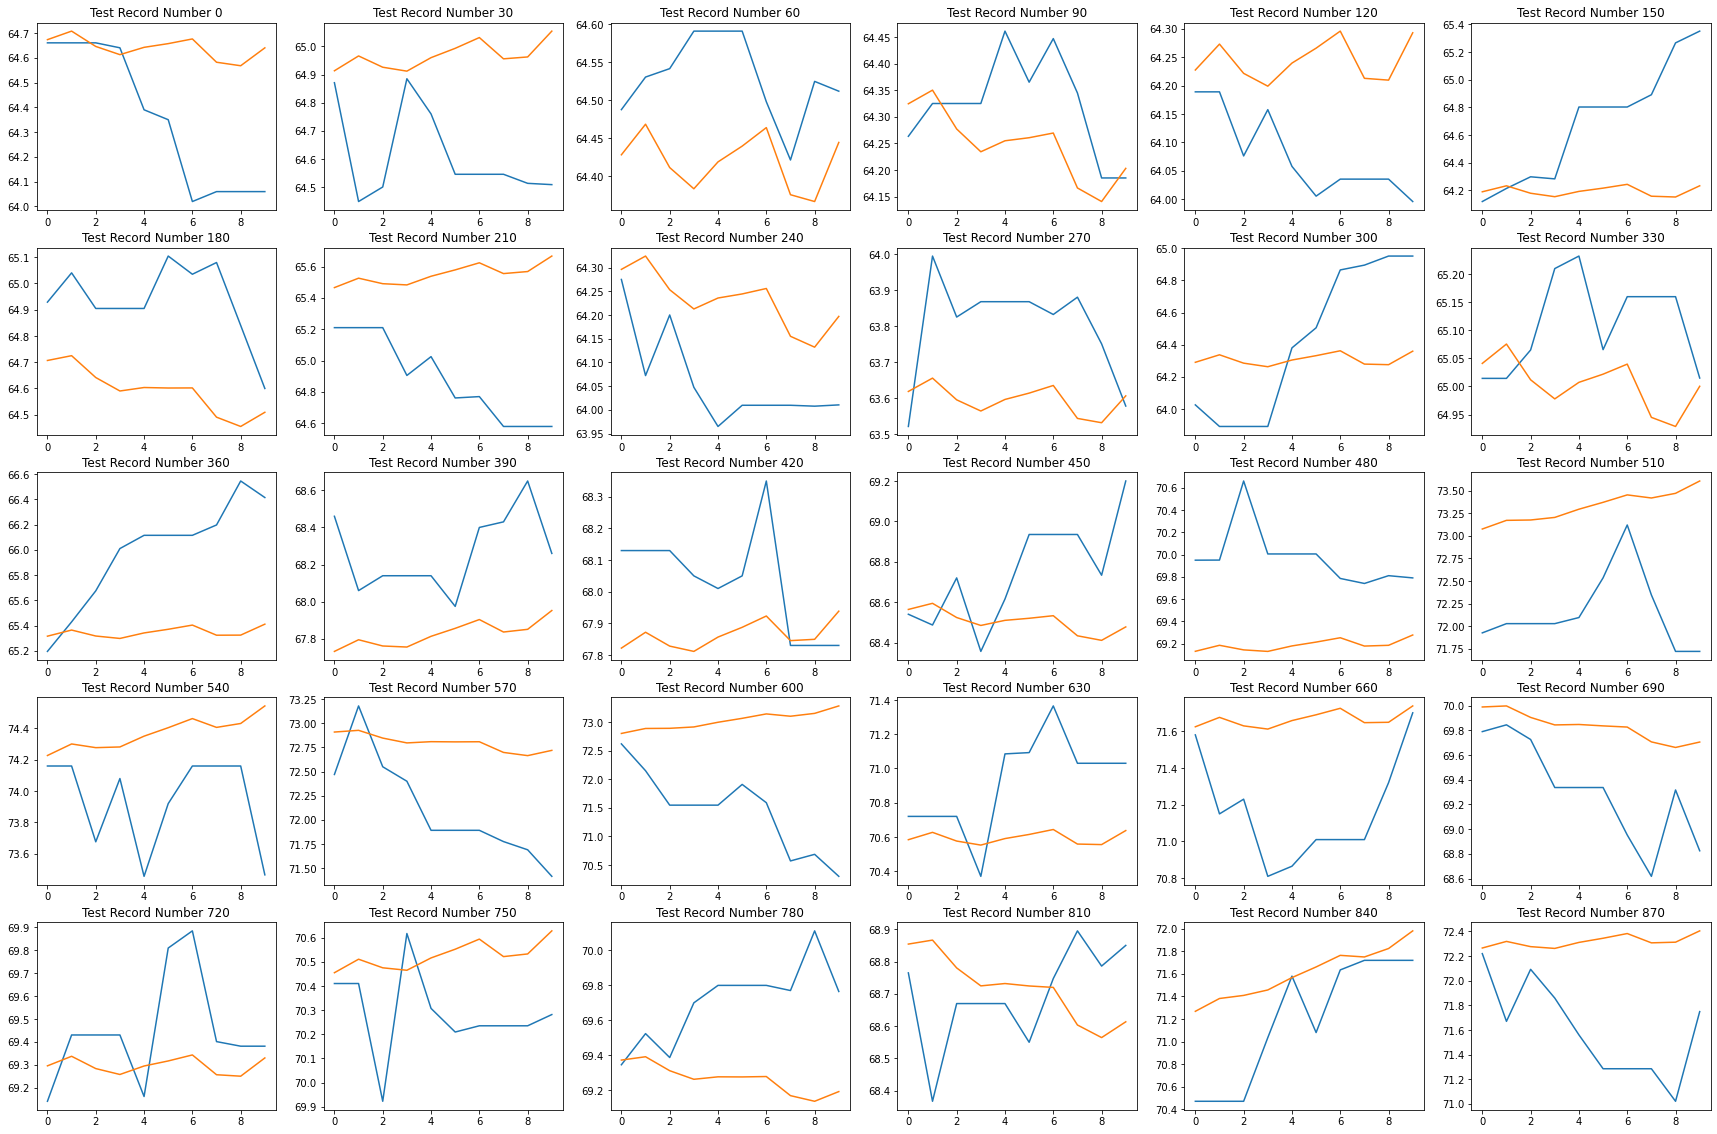

In [ ]:
plt.figure(figsize=(30,20))
for i in range(30):
  plt.subplot(5,6,i+1)
  plt.title('Test Record Number '+str(30*i))
  plt.plot(y_retrend_val[30*i])
  plt.plot(y_retrend_pred[30*i])

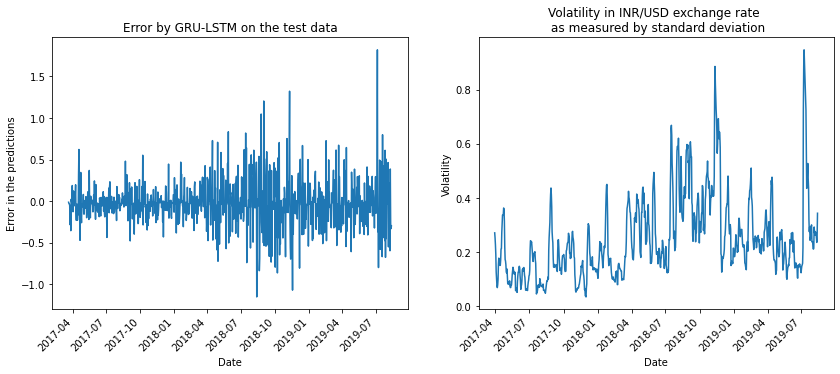

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(df_value[3000:].index[:len(Truth[:,0])],Truth[:,0]- Predictions[:,0])
plt.xlabel('Date')
plt.ylabel('Error in the predictions')
plt.title('Error by GRU-LSTM on the test data')
plt.xticks(rotation=45, ha='right')

# Rolling Volatility 
plt.subplot(1,2,2)
import pandas as pd 
price_list=pd.Series(Truth[:,0]) 
var=10 
rollist=price_list.rolling(var) 
rolvol=rollist.std(ddof=0) 
plt.plot(df_value[3000:].index[:len(Truth[:,0])],rolvol) 
plt.title('Volatility in INR/USD exchange rate \n as measured by standard deviation') 
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show() 